In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from sklearn import metrics
from einops import rearrange

In [2]:
class my_Dataset(Data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

class WheelRailTrajectoryDataset:
    def __init__(self,label=3):
        standard_scaler = StandardScaler()
        self.raw_data1 = pd.read_csv("../dataset/curve_R400.csv")
        self.raw_data2 = pd.read_csv("../dataset/curve_R1000.csv")
        self.raw_data3 = pd.read_csv("../dataset/curve_R2000.csv")
        self.raw_data4 = pd.read_csv("../dataset/curve_R3000.csv")
        self.raw_data5 = pd.read_csv("../dataset/curve_R4000.csv")
        self.raw_data6 = pd.read_csv("../dataset/curve_R5000.csv")
        self.raw_data = pd.concat([self.raw_data1,self.raw_data2,self.raw_data3,self.raw_data4,self.raw_data5,self.raw_data6])
        self.label = label
        #标准化
        self.data = standard_scaler.fit_transform(self.raw_data)
        self.mean = standard_scaler.mean_[label]
        self.sd = math.sqrt(standard_scaler.var_[label])


    def construct_set(self, train_por=0.6,val_por=0.2,test_por=0.2, window_size=100):
        X = []
        Y = []
        list = [self.raw_data1.shape[0],self.raw_data2.shape[0],self.raw_data3.shape[0],self.raw_data4.shape[0],self.raw_data5.shape[0],self.raw_data6.shape[0]]
        num = 0
        for j in range(len(list)):
            if j!=0:
                num = num+list[j-1]
            for i in range(list[j]-window_size):
                seq = self.data[num+i:num+i+window_size+1]
                X.append(seq[0:window_size,:self.label])
                y = seq[window_size:window_size+1,self.label]
                if(y>0.6 or y<-0.6):
                    Y.append(1)
                else:
                    Y.append(0)
        X = np.array(X)
        Y = np.array(Y)
        print(X.shape)
        print(Y.shape)
        train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=test_por,train_size=train_por+val_por,shuffle=True)
        train_x,val_x,train_y,val_y =  train_test_split(train_x,train_y,test_size=val_por/(val_por+train_por),train_size=train_por/(val_por+train_por),shuffle=True)

        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set

TrajectoryData = WheelRailTrajectoryDataset()
train_set, val_set, test_set = TrajectoryData.construct_set()
batch_size = 256
train_loader = Data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = Data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = Data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

(227406, 100, 3)
(227406,)


In [3]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model,seq_len = 100):
        super(PositionalEncoding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(seq_len, d_model+1)
        #维数 seq_len X d_model
        position = torch.arange(0, seq_len).unsqueeze(1) #  维数 seq_lenX1
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        #维数 dmodel/2
        pe[:, 0::2] = torch.sin(position * div_term)
        #维数 seq_len X dmodel/2
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        #维数 1Xseq_lenXd_model
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x batch_size X seq_len X num_features
        #print("x:",x.shape)
        #print("pe:",self.pe.shape)
        x = x + Variable(self.pe[:,:,:x.shape[-1]], requires_grad=False)
        return x

def evaluate_accuracy(data_iter, net, loss,device="cuda"):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        y_hat = y_hat.squeeze()
        acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        l = loss(y_hat, y.long()).sum()
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum/n, test_l_sum/n

def visualization(train_loss,val_loss,train_accuracy,val_accuracy):
    plt.figure(1)
    x1=np.linspace(0,len(train_loss),len(train_loss))
    plt.plot(x1,train_loss,label='train_loss',linewidth=1.5)
    plt.plot(x1,val_loss,label='test_loss',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

    plt.figure(2)
    x2 = np.linspace(0,len(train_accuracy),len(train_accuracy))
    plt.plot(x2,train_accuracy,label='train_accuracy',linewidth=1.5)
    plt.plot(x2,val_accuracy,label='val_accuracy',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

def evaluate_PR(data_iter, net, loss,device="cuda"):
    n = 0
    precision_sum,recall_sum,f1_score_sum = 0.0,0.0,0.0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y.long()).sum()
        y_hat = y_hat.argmax(dim=1)
        y_hat = y_hat.squeeze().cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        precision_sum += metrics.precision_score(y,y_hat)
        recall_sum += metrics.recall_score(y,y_hat)
        f1_score_sum += metrics.f1_score(y,y_hat)
        test_l_sum += l.item()
        #n += y.shape[0]
        n+=1
    return precision_sum/n,recall_sum/n,f1_score_sum/n

device = torch.device("cuda")
lr = 0.0001
epochs=300
loss=nn.CrossEntropyLoss()

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:1009.)
  return F.conv1d(input, weight, bias, self.stride,


epoch1,loss0.0019,train acc 0.828059,val acc 0.862
epoch2,loss0.0017,train acc 0.873531,val acc 0.887
epoch3,loss0.0016,train acc 0.889164,val acc 0.896
epoch4,loss0.0016,train acc 0.903577,val acc 0.910
epoch5,loss0.0016,train acc 0.908570,val acc 0.914
epoch6,loss0.0015,train acc 0.916456,val acc 0.918
epoch7,loss0.0015,train acc 0.916706,val acc 0.907
epoch8,loss0.0015,train acc 0.923931,val acc 0.927
epoch9,loss0.0015,train acc 0.925187,val acc 0.933
epoch10,loss0.0015,train acc 0.929107,val acc 0.927
epoch11,loss0.0015,train acc 0.929702,val acc 0.932
epoch12,loss0.0015,train acc 0.933520,val acc 0.934
epoch13,loss0.0015,train acc 0.934519,val acc 0.933
epoch14,loss0.0015,train acc 0.935951,val acc 0.928
epoch15,loss0.0015,train acc 0.936523,val acc 0.935
epoch16,loss0.0015,train acc 0.938337,val acc 0.943
epoch17,loss0.0015,train acc 0.940672,val acc 0.942
epoch18,loss0.0014,train acc 0.943418,val acc 0.944
epoch19,loss0.0014,train acc 0.943675,val acc 0.929
epoch20,loss0.0014,tr

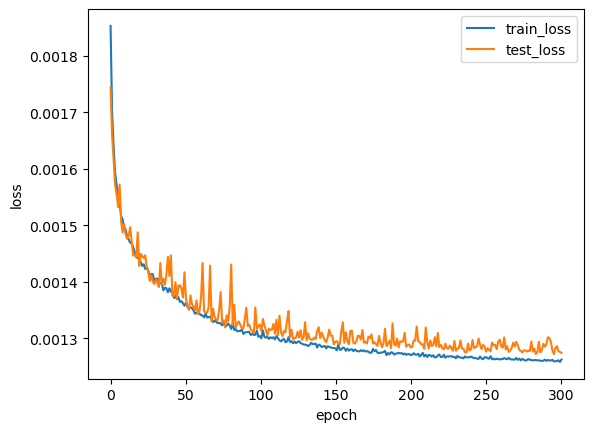

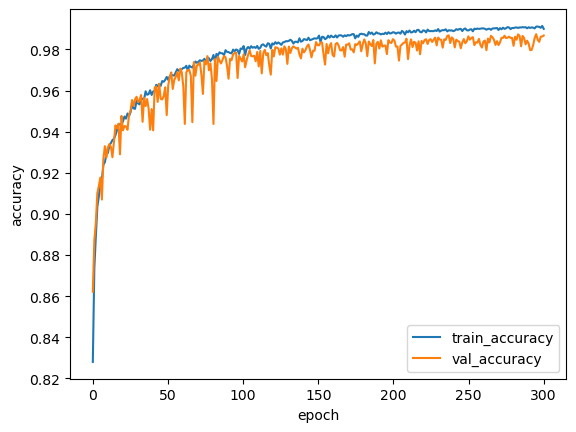

Accuracy on test set : 0.987
test precision: 0.9884861349642897  test recall: 0.9803260104711391  test f1_score: 0.9843105223994322


In [4]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim):
        super(Embedding,self).__init__()
        self.emb = nn.Conv1d(in_channels=1, out_channels=channel_dim,
                             kernel_size=seq_len,padding='same',stride=1,groups=1)

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

class ModernCBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernCBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,
                                kernel_size=seq_len,padding='same',stride=1,groups=variable_dim*channel_dim)


        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim)
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim)
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y = self.conv_s(x)
        y = y + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.pe = PositionalEncoding(variable_dim)
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len*channel_dim,out_features=variable_dim*seq_len*channel_dim//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = self.emb(x) # b v c s
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = self.flatten(features) # b (v*c*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_pe1_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_pe1_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

epoch1,loss0.0019,train acc 0.817985,val acc 0.860
epoch2,loss0.0017,train acc 0.864471,val acc 0.867
epoch3,loss0.0017,train acc 0.885830,val acc 0.881
epoch4,loss0.0016,train acc 0.896962,val acc 0.892
epoch5,loss0.0016,train acc 0.903504,val acc 0.913
epoch6,loss0.0016,train acc 0.911808,val acc 0.912
epoch7,loss0.0015,train acc 0.916001,val acc 0.922
epoch8,loss0.0015,train acc 0.920135,val acc 0.927
epoch9,loss0.0015,train acc 0.923064,val acc 0.923
epoch10,loss0.0015,train acc 0.923153,val acc 0.930
epoch11,loss0.0015,train acc 0.927316,val acc 0.930
epoch12,loss0.0015,train acc 0.929834,val acc 0.927
epoch13,loss0.0015,train acc 0.930730,val acc 0.933
epoch14,loss0.0015,train acc 0.931956,val acc 0.937
epoch15,loss0.0015,train acc 0.933858,val acc 0.936
epoch16,loss0.0015,train acc 0.935275,val acc 0.921
epoch17,loss0.0015,train acc 0.934827,val acc 0.938
epoch18,loss0.0015,train acc 0.938176,val acc 0.942
epoch19,loss0.0015,train acc 0.939336,val acc 0.941
epoch20,loss0.0015,tr

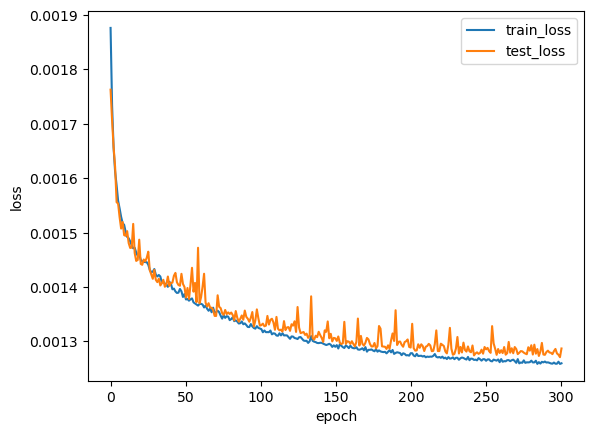

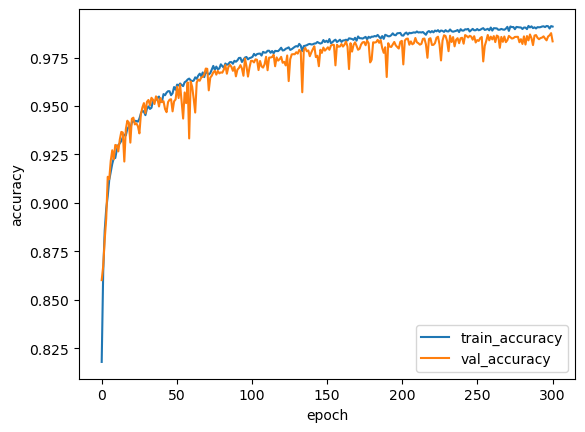

Accuracy on test set : 0.987
test precision: 0.9871169933346988  test recall: 0.9816705883097814  test f1_score: 0.9843077617021505


In [5]:
class ModernCNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernCNet,self).__init__()
        self.pe = PositionalEncoding(variable_dim)
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernCList = nn.ModuleList([ModernCBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len*channel_dim,out_features=variable_dim*seq_len*channel_dim//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len*channel_dim//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = x+self.pe(x)
        x = self.emb(x) # b v c s
        residual = x # b v c s
        features = x
        for block in self.ModernCList:
            features = block(features)
        features = features + residual
        features = self.flatten(features) # b (v*c*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_pe2_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernCNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_pe2_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)